# Data loading and initializations

In [2]:

# Xception or VGG19
APPLICATION                   = 'VGG19'

# to be modified as required in the execution
# I used 0 and 123 to test my results
RANDOM_STATE                  = 0

USE_GOOGLE_DRIVE_FOR_FILES    = True
DATA_FOLDER_PATH              = "/content/drive/My Drive/Data Science/BGU/Machine Learning/Assignments/3/Data"

# name of the folder in the data folder, in which the images are stored.
# when using googel drive, a folder with the same name will be created locally.
# all images are in the format image_<5 chars number>.jpg (e.g: image_00123.jpg)
IMAGES_FOLDER_NAME            = '102-jpg'

# for debug only. leave empty if not in debug mode.
# in debug mode the results will be saved to SAVE_PATH.
RUN_NUMBER                    = "1007"
SAVE_PATH                     = "/content/drive/MyDrive/Data Science/BGU/Machine Learning/Assignments/3/model_files"


In [3]:
from tensorflow.keras.preprocessing           import image
from tensorflow.keras.optimizers              import Adam
from keras                                    import Input, Sequential
from keras.applications.vgg19                 import VGG19, preprocess_input, decode_predictions
from tensorflow.keras.applications.xception   import Xception
from keras.callbacks                          import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.layers                             import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Activation
from keras.models                             import Model, load_model
from sklearn.preprocessing                    import label_binarize
from sklearn.model_selection                  import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os

if APPLICATION == 'Xception':
  image_size = 299
elif APPLICATION == 'VGG19':
  # original is 224, but I get a higher accuracy with 299
  image_size = 299
else:
  raise ValueError(f'APPLICATION {APPLICATION} undefined')

if USE_GOOGLE_DRIVE_FOR_FILES:
  from google.colab import drive
  drive.mount('/content/drive')

# Load labels
df_y = pd.read_csv(f"{DATA_FOLDER_PATH}/102Flowers_labels.csv")

# Load class dictionary
with open(f"{DATA_FOLDER_PATH}/classes_dictionary.txt", 'r') as f:
  classes_dictionary_str = json.loads(f.read())

# convert classes from str to int
classes_dictionary = {}
for k in classes_dictionary_str.keys():
  classes_dictionary[int(k)] = classes_dictionary_str[k]

# load the files locally
if USE_GOOGLE_DRIVE_FOR_FILES and not os.path.exists(IMAGES_FOLDER_NAME):
  os.mkdir(IMAGES_FOLDER_NAME)

if RUN_NUMBER:
  
  save_results = True

  # folder to store files
  if not os.path.exists(f'{SAVE_PATH}/{RUN_NUMBER}'):
    os.mkdir(f"{SAVE_PATH}/{RUN_NUMBER}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:

if USE_GOOGLE_DRIVE_FOR_FILES:
  print("Loading images from drive and saving locally...")
  i=0
  for filename in os.listdir(f"{DATA_FOLDER_PATH}/{IMAGES_FOLDER_NAME}"):
    with open(f"{DATA_FOLDER_PATH}/{IMAGES_FOLDER_NAME}/"+filename, 'rb') as f:
      with open (f'{IMAGES_FOLDER_NAME}/{filename}', 'wb') as fw:
        fw.write(f.read())
        i+=1
        if i%1000 == 0:
          print(i, end=', ')
  print(i)


Loading images from drive and saving locally...
1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 8189


In [4]:

print("Loading images to variable X...")
X = []
for i in range(len(df_y)):
  img = image.load_img(f'{IMAGES_FOLDER_NAME}/image_{str(i+1).zfill(5)}.jpg', target_size=(image_size,image_size))
  X.append(image.img_to_array(img))
  if i%1000 == 0:
    print(i, end=', ')
print(i)

Loading images to variable X...
0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 8188


In [5]:
# For traceability and logging, the IDs of the test will be saved.
# Therefore the train/validation/test splits will be done on the IDs, not the data itself.

X_ids_for_split = pd.DataFrame({'ID':np.arange(len(X))})
y = df_y['y']

# wrong label in the data
y[7592]=96

# Split: 50% train, 25% validation, 25% test

X_temp, X_test_ids_for_split, y_temp, y_test = train_test_split(
    X_ids_for_split, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

X_train_ids_for_split, X_valid_ids_for_split, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.3333, random_state=RANDOM_STATE, stratify=y_temp)


X_test = [X[i] for i in list(X_test_ids_for_split['ID'])]
X_valid = [X[i] for i in list(X_valid_ids_for_split['ID'])]
X_train = [X[i] for i in list(X_train_ids_for_split['ID'])]

# save test IDs for debug
if save_results:
  X_test_ids_for_split.to_csv(f'{SAVE_PATH}/{RUN_NUMBER}/X_test_IDs.csv')


X_test = np.array(X_test)
X_valid = np.array(X_valid)
X_train = np.array(X_train)

classes = list(classes_dictionary.keys())
classes.sort()

y_test = label_binarize(np.array(y_test), classes = classes)
y_valid = label_binarize(np.array(y_valid), classes = classes)
y_train = label_binarize(np.array(y_train), classes = classes)


In [6]:
# free up memory
del X
del X_temp
del X_ids_for_split
del X_train_ids_for_split
del X_valid_ids_for_split
del X_test_ids_for_split
del df_y
del y_temp
del y


# Transfer learning model

In [7]:

if APPLICATION == 'Xception':

  # Xception weights requires that input be scaled from (0, 255) to a range of (-1., +1.)
  X_test = X_test / 127.5 - 1.
  X_valid = X_valid / 127.5 - 1.
  X_train = X_train / 127.5 - 1.

elif APPLICATION == 'VGG19':

  # subtracting the mean RGB value, computed on the training set, from each pixel
  X_test = preprocess_input(X_test)
  X_valid = preprocess_input(X_valid)
  X_train = preprocess_input(X_train)


In [8]:
# short run params

# num_epochs = 30
# learning_rate = 1 * 1e-3
# early_stopping_patience = 4
# early_stopping_min_delta = 0.003

# long run params
num_epochs = 120
learning_rate = 1e-4

optimizer = Adam(learning_rate=learning_rate) 

model_file_prefix = f'{SAVE_PATH}/{RUN_NUMBER}/{RANDOM_STATE}' 

# callback 1: early stopping (for short runs)
#es = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, min_delta=early_stopping_min_delta, verbose=1)

# callback 2: model checkpoint
cp = ModelCheckpoint(filepath=model_file_prefix + '_best_model.h5', mode='max', monitor='val_accuracy', save_best_only=True, verbose=1)

# callback 3: reduce learning rate on plateau. all values are default except verbose.
reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.1,
                              patience=10,
                              verbose=1,
                              mode="auto",
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0
                              )

# For fitting few times in a sequence, use validation_data = (X_valid, y_valid), otherwise use validation_split. Here I use it like that for control and debugging
validation_data = (X_valid, y_valid)

# include_top=False --> get the outputs of the convolution layers, before the FC layers
if APPLICATION == 'Xception':

  base_model = Xception(input_shape=[image_size, image_size, 3], weights='imagenet', include_top=False)

  base_model.trainable = False

  inputs = Input(shape=(image_size, image_size, 3))

  o = base_model(inputs, training=False)
  o = GlobalAveragePooling2D()(o)
  o = Dense(512)(o)
  o = BatchNormalization()(o)
  o = Activation('relu')(o)
  o = Dropout(rate=0.3, seed=RANDOM_STATE)(o)

elif APPLICATION == 'VGG19':

  base_model = VGG19(input_shape=[image_size, image_size, 3], weights='imagenet', include_top=False)

  base_model.trainable = False

  inputs = Input(shape=(image_size, image_size, 3))

  o = base_model(inputs, training=False)
  o = GlobalAveragePooling2D()(o)
  o = Dense(1024)(o)
  o = BatchNormalization()(o)
  o = Activation('relu')(o)
  o = Dropout(rate=0.3, seed=RANDOM_STATE)(o)
  


predictions = Dense(len(classes_dictionary), activation='softmax')(o)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer=optimizer,  loss='categorical_crossentropy', metrics=["accuracy"])



In [9]:
# free up some memory
del X_valid
del y_valid

In [10]:
history_test={'test_loss': [], 'test_accuracy': []}

class EvaluateEpochEnd(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        #super().on_epoch_end(epoch, logs)
        x, y = self.test_data
        scores = self.model.evaluate(x, y, verbose=False)
        history_test['test_loss'].append(scores[0])
        history_test['test_accuracy'].append(scores[1])
        print('\nTesting loss: {}, accuracy: {}\n'.format(scores[0], scores[1]))

class EpochModelCheckpoint(ModelCheckpoint):

    def __init__(self,
                 filepath,
                 frequency=1,
                 monitor='val_loss',
                 verbose=0,
                 save_best_only=False,
                 save_weights_only=False,
                 mode='auto',
                 options=None,
                 **kwargs):
        super(EpochModelCheckpoint, self).__init__(filepath, monitor, verbose, save_best_only, save_weights_only,
                                                   mode, "epoch", options)
        self.epochs_since_last_save = 0
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        self.epochs_since_last_save += 1
        # pylint: disable=protected-access
        if self.epochs_since_last_save % self.frequency == 0:
            self._save_model(epoch=epoch, batch=None, logs=logs)

    def on_train_batch_end(self, batch, logs=None):
        pass

In [11]:
# due to the size of the tensors, the call below fails (out of memory) when it tries to run the callback EvaluateEpochEnd.
#history = model.fit(x=X_train, y=y_train, epochs=num_epochs, validation_data=validation_data, callbacks=[cp, reduce_lr, EvaluateEpochEnd((X_test, y_test))])

# ALTERNATIVE: therefore I used another callback that saves the model every 10 epochs. I calculate the test loss and accuracy on these checkpoints after the run is finished.
history = model.fit(x=X_train, y=y_train, epochs=num_epochs, validation_data=validation_data, callbacks=[cp, reduce_lr, EpochModelCheckpoint(model_file_prefix + '_epoch_{epoch:03d}.h5', frequency=10)])


#short:
#history = model.fit(x=X_train, y=y_train, epochs=num_epochs, validation_data=validation_data, callbacks=[cp, es])


# print all the run history, that can be used later on for the graphs
print("RUN HISTORY:\n")
print(history.history.keys())
print(history.history.values())

Epoch 1/120
128/128 [==============================] - ETA: 0s - loss: 4.0027 - accuracy: 0.1558
Epoch 1: val_accuracy improved from -inf to 0.38984, saving model to /content/drive/MyDrive/Data Science/BGU/Machine Learning/Assignments/3/model_files/1007/0_best_model.h5
128/128 [==============================] - 44s 297ms/step - loss: 4.0027 - accuracy: 0.1558 - val_loss: 2.7548 - val_accuracy: 0.3898 - lr: 1.0000e-04
Epoch 2/120
128/128 [==============================] - ETA: 0s - loss: 2.3568 - accuracy: 0.4985
Epoch 2: val_accuracy improved from 0.38984 to 0.63556, saving model to /content/drive/MyDrive/Data Science/BGU/Machine Learning/Assignments/3/model_files/1007/0_best_model.h5
128/128 [==============================] - 32s 255ms/step - loss: 2.3568 - accuracy: 0.4985 - val_loss: 1.8699 - val_accuracy: 0.6356 - lr: 1.0000e-04
Epoch 3/120
128/128 [==============================] - ETA: 0s - loss: 1.6449 - accuracy: 0.6629
Epoch 3: val_accuracy improved from 0.63556 to 0.72545, sa

In [12]:
del X_train

In [13]:
# as mentioned in the ALTERNATIVE above, after the run the saved models are loaded to predict the test accuracy and loss every 10th epoch 
for i in range(10, num_epochs+1, 10):
  final_model = load_model(f'{model_file_prefix}_epoch_{i:03d}.h5')
  scores = final_model.evaluate(X_test,y_test)
  history_test['test_loss'].append(scores[0])
  history_test['test_accuracy'].append(scores[1])


64/64 [==============================] - 13s 207ms/step - loss: 0.2439 - accuracy: 0.9326


In [15]:
plot_data = {}

plot_data_keys = list(history.history.keys())
#plot_data_keys = ['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr']
plot_data_values = list(history.history.values())
#plot_data_values = [lss0,acc0,lss,acc,[]]

for i in range(len(plot_data_keys)):
  plot_data[plot_data_keys[i]] = plot_data_values[i]
  

In [16]:
# best model predictions
final_model = load_model(model_file_prefix + '_best_model.h5')
scores = final_model.evaluate(X_test,y_test)
print(scores)

best_epic_number = 69

# will be used in the plot

64/64 [==============================] - 13s 206ms/step - loss: 0.2490 - accuracy: 0.9312
[0.24896840751171112, 0.93115234375]


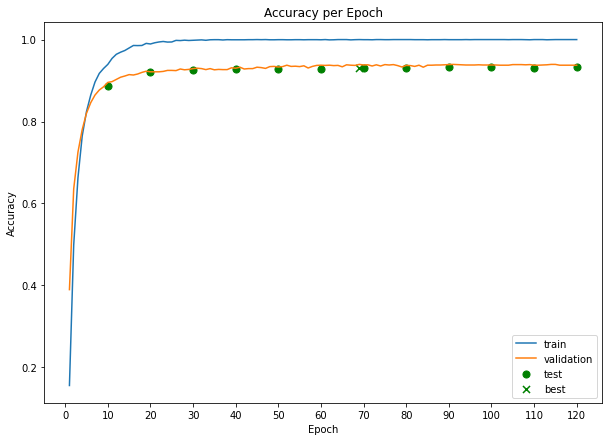

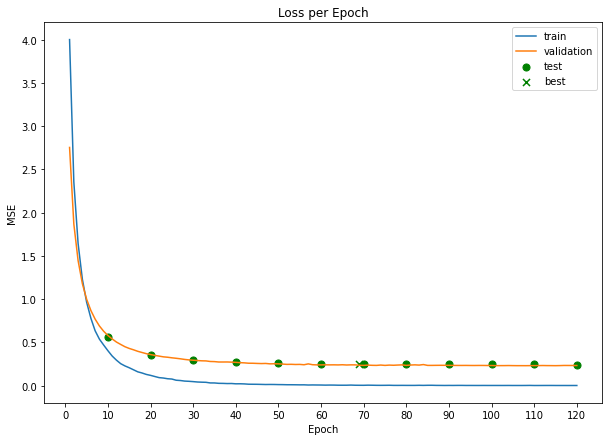

In [17]:
num_of_x_values = len(plot_data_values[0])

# summarize history for accuracy
fig = plt.figure(figsize = (10, 7))
plt.plot(np.arange(1,num_of_x_values+1), plot_data['accuracy'])
plt.plot(np.arange(1,num_of_x_values+1), plot_data['val_accuracy'])
plt.scatter(np.arange(10,num_of_x_values+1, 10), history_test['test_accuracy'], s=50, color='green')
plt.scatter([best_epic_number], scores[1], s=50, color='green', marker='x')


plt.title('Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,num_of_x_values+1,10))

plt.legend(['train', 'validation', 'test', 'best'], loc='lower right')
plt.show()

# summarize history for loss
fig = plt.figure(figsize = (10, 7))
plt.plot(np.arange(1,num_of_x_values+1), plot_data['loss'])
plt.plot(np.arange(1,num_of_x_values+1), plot_data['val_loss'])
plt.scatter(np.arange(10,num_of_x_values+1, 10), history_test['test_loss'], s=50, color='green')
plt.scatter([best_epic_number], scores[0], s=50, color='green', marker='x')

plt.title('Loss per Epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')
#plt.xticks(np.arange(1,len(history.epoch)+1))
plt.xticks(np.arange(0,num_of_x_values+1,10))
plt.legend(['train', 'validation', 'test', 'best'], loc='upper right')
plt.show()


In [9]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 9, 9, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1024)              0     

#Extracting the 102Flowers dataset labels

In [66]:
URL = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"

# 1. Import the requests library
import requests

# 2. download the data behind the URL
response = requests.get(URL)
# 3. Open the response into a new file called instagram.ico
open("my_lables.mat", "wb").write(response.content)


502

In [67]:
import scipy.io
mat = scipy.io.loadmat('my_lables.mat')

In [68]:
mat

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}

In [ ]:
df = pd.DataFrame(mat['labels'].T)
df

In [65]:
import pandas as pd
df = pd.DataFrame(mat['labels'].T)
df.to_csv('102Flowers_labels.csv')